<a href="https://colab.research.google.com/github/ElenaVillano/sentiment_analysis_tweets/blob/main/notebooks/modelado_ejemplo_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
!pip install "git+https://github.com/ElenaVillano/sentiment_analysis_tweets.git#egg=nlptweet&subdirectory=src" --quiet

In [ ]:
#!pip uninstall nlptweet

Uninstalling nlptweet-0.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/nlp/*
    /usr/local/lib/python3.7/dist-packages/nlptweet-0.1.dist-info/*
Proceed (y/n)? yes
Your response ('yes') was not one of the expected responses: y, n
Proceed (y/n)? y
  Successfully uninstalled nlptweet-0.1


In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import nltk
#import re
import timeit
import string
# Nuestro paquete
import nlp


#call the nltk downloader
nltk.download('punkt')

from dateutil import parser

# Carga un set de stopwords predefinidas
from nltk.corpus import stopwords

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Nombramiento de columnas
col_names = ['target', # Polaridad del twet 0=negativo, 2=neutral, 4=positivo
             'ids',    # ID tweet
             'date',   # Fecha y hora del tweet
             'flag',   # QUERY
             'user',   # Usuario del tweet
             'text']   # Texto del tweety

# Carga y limpieza de datos

In [5]:
# Requiered to select a file to be imported into colab
# Not useful if running locally
from google.colab import files
uploaded = files.upload()

Saving smaller_sample_200000.csv to smaller_sample_200000.csv
Saving testdata_manual_2009_06_14.csv to testdata_manual_2009_06_14.csv


In [6]:
training =  pd.read_csv('smaller_sample_200000.csv',
                 encoding='latin-1')

In [7]:
test = pd.read_csv('testdata_manual_2009_06_14.csv', names=col_names)

In [8]:
print(training.shape)
print(test.shape)

(200000, 6)
(498, 6)


In [9]:
# Ejemplo
training.loc[[4,8,27,41,44,35,48,155]]

,target,ids,date,flag,user,text
4,0,2250671573,Sat Jun 20 01:09:32 PDT 2009,NO_QUERY,evilcaz,Far too tired to be at work
8,0,2233840533,Thu Jun 18 21:59:23 PDT 2009,NO_QUERY,TiffanyNicoleN,"I wish today never happened. On top of that, I..."
27,0,2254342354,Sat Jun 20 09:36:05 PDT 2009,NO_QUERY,AJMcCleary,"@ReallyShecky - Indeed, come on down. The sick..."
41,4,1794361968,Thu May 14 05:38:02 PDT 2009,NO_QUERY,cherrybomb54,Now I get to make incredibly long Tweets thank...
44,0,1686244630,Sun May 03 04:31:06 PDT 2009,NO_QUERY,anggieholics,btw whats wrong w/ being single? and if i turn...
35,4,2064953318,Sun Jun 07 07:33:41 PDT 2009,NO_QUERY,heidirenee92,@allucha It would be a good idea not to mess w...
48,4,2004632930,Tue Jun 02 08:30:15 PDT 2009,NO_QUERY,Hadari_B,At a birthday party of a friend !
155,4,1687038778,Sun May 03 07:34:54 PDT 2009,NO_QUERY,lynettebrennan,"is relaxing on the couch, Sundays are the best"


In [10]:
# primera parte limpieza
from nlp.preprocessing import convierte_a_minusculas, reemplazar_urls, reemplazar_usuarios, quitar_hashtag
# minusculas
training = convierte_a_minusculas(training)
test = convierte_a_minusculas(test)
# url
training['text'] = training['text'].map(lambda s: reemplazar_urls(s))
test['text'] = test['text'].map(lambda s: reemplazar_urls(s))
# user_mention
training['text'] = training['text'].map(lambda s: reemplazar_usuarios(s))
test['text'] = test['text'].map(lambda s: reemplazar_usuarios(s))
# hashtags
training['text'] = training['text'].map(lambda s: quitar_hashtag(s))
test['text'] = test['text'].map(lambda s: quitar_hashtag(s))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
# Ejemplo
training.loc[[4,8,27,41,44,35,48,155]]

,target,ids,date,flag,user,text
4,0,2250671573,sat jun 20 01:09:32 pdt 2009,no_query,evilcaz,far too tired to be at work
8,0,2233840533,thu jun 18 21:59:23 pdt 2009,no_query,tiffanynicolen,"i wish today never happened. on top of that, i..."
27,0,2254342354,sat jun 20 09:36:05 pdt 2009,no_query,ajmccleary,"user_mention - indeed, come on down. the sick ..."
41,4,1794361968,thu may 14 05:38:02 pdt 2009,no_query,cherrybomb54,now i get to make incredibly long tweets thank...
44,0,1686244630,sun may 03 04:31:06 pdt 2009,no_query,anggieholics,btw whats wrong w/ being single? and if i turn...
35,4,2064953318,sun jun 07 07:33:41 pdt 2009,no_query,heidirenee92,user_mention it would be a good idea not to me...
48,4,2004632930,tue jun 02 08:30:15 pdt 2009,no_query,hadari_b,at a birthday party of a friend !
155,4,1687038778,sun may 03 07:34:54 pdt 2009,no_query,lynettebrennan,"is relaxing on the couch, sundays are the best"


In [12]:
# segunda parte limpieza
from nlp.preprocessing import quitar_RT, quitar_caracteres_especiales, quitar_letras_repetidas
# retweets
training['text'] = training['text'].map(lambda s: quitar_RT(s))
test['text'] = test['text'].map(lambda s: quitar_RT(s))
# caracteres especiales
training['text'] = training['text'].map(lambda s: quitar_caracteres_especiales(s))
test['text'] = test['text'].map(lambda s: quitar_caracteres_especiales(s))
# letras repetidas
training['text'] = training['text'].map(lambda s: quitar_letras_repetidas(s))
test['text'] = test['text'].map(lambda s: quitar_letras_repetidas(s))

In [13]:
# Ejemplo
training.loc[[4,8,27,41,44,35,48,155]]

,target,ids,date,flag,user,text
4,0,2250671573,sat jun 20 01:09:32 pdt 2009,no_query,evilcaz,far too tired to be at work
8,0,2233840533,thu jun 18 21:59:23 pdt 2009,no_query,tiffanynicolen,i wish today never happened on top of that i m...
27,0,2254342354,sat jun 20 09:36:05 pdt 2009,no_query,ajmccleary,user_mention indeed come on down the sick hea...
41,4,1794361968,thu may 14 05:38:02 pdt 2009,no_query,cherrybomb54,now i get to make incredibly long tweets thank...
44,0,1686244630,sun may 03 04:31:06 pdt 2009,no_query,anggieholics,btw whats wrong w/ being single and if i turn ...
35,4,2064953318,sun jun 07 07:33:41 pdt 2009,no_query,heidirenee92,user_mention it would be a good idea not to me...
48,4,2004632930,tue jun 02 08:30:15 pdt 2009,no_query,hadari_b,at a birthday party of a friend
155,4,1687038778,sun may 03 07:34:54 pdt 2009,no_query,lynettebrennan,is relaxing on the couch sundays are the best


In [15]:
# tercera parte limpieza
from nlp.preprocessing import quitar_nonascii, separar_abreviaciones, remove_stopwords, oracion_raiz
#nonascii
training['text'] = training['text'].map(lambda s: quitar_nonascii(s))
test['text'] = test['text'].map(lambda s: quitar_nonascii(s))
# abreviaciones
training['text'] = training['text'].map(lambda s: separar_abreviaciones(s))
test['text'] = test['text'].map(lambda s: separar_abreviaciones(s))
# stop words
training['text'] = training['text'].map(lambda s: remove_stopwords(s))
test['atext'] = test['text'].map(lambda s: remove_stopwords(s))
# raiz
training['text'] = training['text'].map(lambda s: oracion_raiz(s))
test['atext'] = test['text'].map(lambda s: oracion_raiz(s))

In [16]:
# Ejemplo
training.loc[[4,8,27,41,44,35,48,155]]

,target,ids,date,flag,user,text
4,0,2250671573,sat jun 20 01:09:32 pdt 2009,no_query,evilcaz,far tire work
8,0,2233840533,thu jun 18 21:59:23 pdt 2009,no_query,tiffanynicolen,wish today never happen top miss user_ment get...
27,0,2254342354,sat jun 20 09:36:05 pdt 2009,no_query,ajmccleary,user_ment inde come sick heat realli quit refr...
41,4,1794361968,thu may 14 05:38:02 pdt 2009,no_query,cherrybomb54,get make incred long tweet thank twitzer googl
44,0,1686244630,sun may 03 04:31:06 pdt 2009,no_query,anggieholics,btw what wrong w/ singl turn lesbian let u know
35,4,2064953318,sun jun 07 07:33:41 pdt 2009,no_query,heidirenee92,user_ment would good idea mess mr potatoheadju...
48,4,2004632930,tue jun 02 08:30:15 pdt 2009,no_query,hadari_b,birthday parti friend
155,4,1687038778,sun may 03 07:34:54 pdt 2009,no_query,lynettebrennan,relax couch sunday best


In [81]:
training.text

0         user_ment wellnot breakup speech per sebut go ...
1                                 state slow seem pick bit 
2         user_ment hey help user_ment take url behind a...
3         aw man user_ment think make see chang thing wo...
4                                            far tire work 
                                ...                        
199995       user_ment think kati perri remind situat kirk 
199996    would bf build someth w/n would much would get...
199997    tip finger hurt nervou school store tomorrow p...
199998                                    url chillin pool 
199999                      pick dog doctor note back work 
Name: text, Length: 200000, dtype: object

# Entrenamos un Tokenizer

In [36]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers

In [64]:
# Entrena un Tokenizer. Consiste en:
# Crea un diccionario numerado de las palabras existentes en el corpus, y devuelve
# por cada palabra, el número entero de su índice en el diccionario.
# En este caso, considera las N palabras más frecuentes.
# oov_token = constante asiganda para palabras fuera del vocabulario (NOT USED HERE)
data_set_1 = training
data_set_1.shape
data_set_1.text

0         user_ment wellnot breakup speech per sebut go ...
1                                 state slow seem pick bit 
2         user_ment hey help user_ment take url behind a...
3         aw man user_ment think make see chang thing wo...
4                                            far tire work 
                                ...                        
199995       user_ment think kati perri remind situat kirk 
199996    would bf build someth w/n would much would get...
199997    tip finger hurt nervou school store tomorrow p...
199998                                    url chillin pool 
199999                      pick dog doctor note back work 
Name: text, Length: 200000, dtype: object

In [82]:
max_words = 5000
max_len = 128

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data_set_1.text)

print("Number of words in the dictionary", len(tokenizer.word_index))
print(list(tokenizer.word_index.items())[:10])

Number of words in the dictionary 81792
[('ment', 1), ('user', 2), ('go', 3), ('get', 4), ('day', 5), ('good', 6), ('work', 7), ('like', 8), ('love', 9), ('url', 10)]


In [72]:
#sorted(tokenizer.word_counts.values())[:10]
#Tokenizer?

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [83]:
# Convierte palabras en enteros
train_sequences = tokenizer.texts_to_sequences(data_set_1.text)
lengths = []
for seq in train_sequences:
  lengths.append(len(seq))

print("Tweet más pequeño", np.array(lengths).min(), "words.")
print("Tweet más grande", np.array(lengths).max(), "words.")
print(f"Longitud promedio: {np.array(lengths).mean():.2f} +- {np.array(lengths).std():.2f} words.")
print('\n')

for seq in train_sequences[:10]:
  print(seq)

Tweet más pequeño 0 words.
Tweet más grande 46 words.
Longitud promedio: 7.30 +- 3.74 words.


[2, 1, 2053, 1888, 3, 146, 501, 767, 160, 19, 382, 69, 54]
[824, 627, 242, 408, 174]
[2, 1, 88, 127, 2, 1, 68, 10, 807, 197, 19, 1532, 2, 1, 19, 813]
[334, 144, 2, 1, 24, 34, 23, 276, 63, 7, 3]
[279, 110, 7]
[2, 1, 523, 162, 198, 357]
[2, 1, 635, 795, 50, 2228, 64, 837]
[2, 1, 284, 46, 200, 352, 482, 874, 1434, 4680, 2137]
[50, 12, 99, 195, 480, 15, 2, 1, 4, 325, 67]
[4, 138, 3, 18, 18, 3233, 257, 3697, 4941, 287]


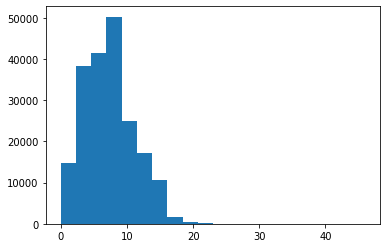

In [71]:
plt.hist(lengths,20)
plt.show()

In [84]:
sequences = tokenizer.texts_to_sequences(data_set_1.text)
tweets = pad_sequences(sequences, maxlen=max_len, padding='pos')
print(tweets)

[[   0    0    0 ...  382   69   54]
 [   0    0    0 ...  242  408  174]
 [   0    0    0 ...    1   19  813]
 ...
 [   0    0    0 ...   49   81   41]
 [   0    0    0 ...   10 1071  588]
 [   0    0    0 ...  765   17    7]]


In [86]:
tweets.shape

(200000, 128)

In [88]:
data_set_1.target.shape

(200000,)

## Separamos en train, test

In [89]:
from sklearn.model_selection import train_test_split

In [90]:
X_train, X_test, y_train, y_test = train_test_split(tweets, data_set_1.target.values, test_size=0.3, random_state=23042021)

In [91]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (140000, 128)
y_train (140000,)
X_test (60000, 128)
y_test (60000,)


In [92]:
y_train = np.where(y_train==4,1,y_train)
y_test = np.where(y_test==4,1,y_test)

In [93]:
y_train
y_test

array([1, 0, 0, ..., 0, 1, 1])

# Creamos el modelo

In [94]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1

In [95]:
# Crea una red con layers Embedding, LSTM, Dense
model = Sequential()
model.add(Embedding(input_length=128, input_dim=max_words, output_dim=64, trainable=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(units=82, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation=None))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 128, 64)           320000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 82)                5330      
_________________________________________________________________
dropout_16 (Dropout)         (None, 82)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 83        
Total params: 358,437
Trainable params: 358,437
Non-trainable params: 0
________________________________________________

In [96]:
# Compile
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=[tf.metrics.BinaryAccuracy(), 'accuracy'])

In [97]:
%%timeit

# Train it
history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_split=0.2)

Epoch 1/5
7000/7000 [==============================] - 82s 12ms/step - loss: 0.5514 - binary_accuracy: 0.6899 - accuracy: 0.6899 - val_loss: 0.5068 - val_binary_accuracy: 0.7240 - val_accuracy: 0.7240
Epoch 2/5
7000/7000 [==============================] - 81s 12ms/step - loss: 0.4681 - binary_accuracy: 0.7635 - accuracy: 0.7635 - val_loss: 0.4921 - val_binary_accuracy: 0.7425 - val_accuracy: 0.7425
Epoch 3/5
7000/7000 [==============================] - 82s 12ms/step - loss: 0.4390 - binary_accuracy: 0.7811 - accuracy: 0.7811 - val_loss: 0.4959 - val_binary_accuracy: 0.7550 - val_accuracy: 0.7550
Epoch 4/5
7000/7000 [==============================] - 82s 12ms/step - loss: 0.4130 - binary_accuracy: 0.7965 - accuracy: 0.7965 - val_loss: 0.5235 - val_binary_accuracy: 0.7538 - val_accuracy: 0.7538
Epoch 5/5
7000/7000 [==============================] - 82s 12ms/step - loss: 0.3904 - binary_accuracy: 0.8093 - accuracy: 0.8093 - val_loss: 0.5331 - val_binary_accuracy: 0.7501 - val_accuracy: 0.

In [110]:
history

checkpoint2 = ModelCheckpoint("rnn_model.hdf5", monitor='val_accuracy', verbose=1,
                              save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test),callbacks=[checkpoint2])
!pip install "git+https://github.com/ElenaVillano/sentiment_analysis_tweets.git#egg=nlptweet&subdirectory=src" --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import nltk
#import re
import timeit
import string
# Nuestro paquete
import nlp


#call the nltk downloader
nltk.download('punkt')

from dateutil import parser

# Carga un set de stopwords predefinidas
from nltk.corpus import stopwords

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
# Nombramiento de columnas
col_names = ['target', # Polaridad del twet 0=negativo, 2=neutral, 4=positivo
             'ids',    # ID tweet

NameError: ignored

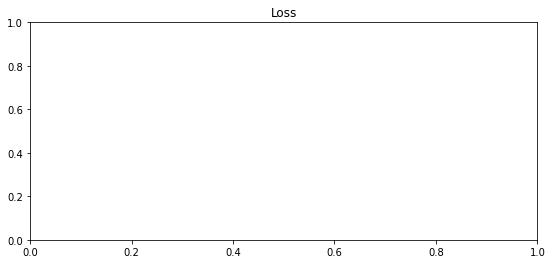

In [108]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()